# Example of application to matlab files and (partial) replication of results from Anderson et al. 2016

In [1]:
import numpy as np
import scipy.io
import os
import xarray as xr
import pyhsmm_mvpa as hsmm
import itertools
import multiprocessing 
import matplotlib.pyplot as plt
from mne import channels

cpus = multiprocessing.cpu_count()

%load_ext autoreload
%autoreload 2


Reading the data

In [2]:
mat = scipy.io.loadmat('matlab/analysis_data_model/data/varForBumps135_100.mat')

data = np.array(mat['normedscore10'])
starts = np.array(mat['x'][:,0]) -1#correcting to be 0 indexed
ends = np.array(mat['y'][:,0])-1#correcting to be 0 indexed
subjects = np.array(mat['subjects'])-1 #correcting to be 0 indexed

#### Converting to xarray format 
durations = ends - starts + 1
limits = np.cumsum(durations)
limits = np.concatenate([[0],limits])
participant, trials = np.unique(subjects, return_counts=True)
unstacked_data = np.tile(np.nan, (len(participant), np.max(trials), np.max(durations), np.shape(data)[1]))

for trial in np.arange(len(durations)):
    if trial > 0 and subjects[trial] == subjects[trial-1]:
        within_trial += 1
    else:
        within_trial = 0
    unstacked_data[subjects[trial], within_trial, :durations[trial],:] = data[limits[trial]:limits[trial+1]]
unstacked_data = xr.DataArray(unstacked_data, coords={'participant':participant,
                                   'epochs':np.arange(np.max(trials)),
                                   'samples':np.arange(np.max(durations)),
                                   'component':np.arange(np.shape(data)[1])
                               })
stacked_data = hsmm.stack_data(unstacked_data, 'participant')
unstacked_data

<xarray.DataArray (participant: 20, epochs: 789, samples: 300, component: 10)>
array([[[[ 2.29389191e+00, -7.00917125e-01, -9.65582013e-01, ...,
          -1.02805626e+00, -2.00418770e-01,  5.86517481e-03],
         [ 2.60667229e+00, -4.60338086e-01, -7.71695435e-01, ...,
          -9.53093946e-01, -6.32156610e-01, -5.46043217e-01],
         [ 2.31114078e+00, -2.60357320e-01, -5.86097300e-01, ...,
          -5.13598025e-01, -1.08038738e-01, -9.39393938e-01],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[ 3.20236385e-01,  2.64478326e+00, -1.27864850e+00, ...,
          -5.08165240e-01,  6.23414636e-01,  1.07119465e+00],
         [ 7.64930904e-01,  2.14959526e+00, -1.96315598e+00, ...,
          -1.28758729e+00,  1.38161147e+00,  9.14184213e-01],
         [ 3.57478350e-01,  1.41175854e+00, -2.23004580e+00, ...,
          -9.54845607e-01,  1.06723702e+00,  8.27223718e-01],
...
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]]]])
Coordinates:
  * participant  (participant) uint8 0 1 2 3 4 5 6 7 ... 12 13 14 15 16 17 18 19
  * epochs       (epochs) int64 0 1 2 3 4 5 6 7 ... 782 783 784 785 786 787 788
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 293 294 295 296 297 298 299
  * component    (component) int64 0 1 2 3 4 5 6 7 8 9

Recreating positions of electrodes

In [3]:
channels_loc = scipy.io.loadmat('matlab/analysis_data_model/analysis/HSMM_code/chanlocs.mat')
positions_dict_i =  [{str(electrode[0][0]):[-electrode[5][0][0]/1000,electrode[4][0][0]/1000,electrode[6][0][0]/1000]} 
                     for electrode in channels_loc['chanlocs'][0]]
positions_dict = {}
for i in positions_dict_i:
     positions_dict.update(i)
montage = channels.make_dig_montage(positions_dict,coord_frame='head')
positions = np.array([x[-1][:2] for x in np.array(list(montage.get_positions()['ch_pos'].items()),dtype=object)[:,:]])
names = np.array([x[0] for x in np.array(list(montage.get_positions()['ch_pos'].items()),dtype=object)[:,:]])
#montage.plot();

Initializing the hsmm object with data, starts, sampling frequency... all things shared across the different following fit

In [4]:
init = hsmm.hsmm(stacked_data.data, starts, ends, sf=100, bump_width=50, cpus=5)

Estimating n_bump model with backward estimation

In [5]:
filename = 'testing.nc'

if filename not in os.listdir():
    bests = init.backward_estimation()
    bests.to_netcdf('testing.nc')
else:
    bests = xr.open_dataset('testing.nc')
bests

<xarray.Dataset>
Dimensions:      (n_bumps: 8, stage: 9, params: 2, component: 10, bump: 8,
                  samples: 300, trial: 14496)
Coordinates:
  * n_bumps      (n_bumps) int64 8 7 6 5 4 3 2 1
Dimensions without coordinates: stage, params, component, bump, samples, trial
Data variables:
    likelihoods  (n_bumps) float64 ...
    parameters   (n_bumps, stage, params) float64 ...
    magnitudes   (n_bumps, component, bump) float64 ...
    eventprobs   (n_bumps, samples, trial, bump) float64 ...

Plotting the likelihood and estimated bumps

In [6]:
electrodes = xr.DataArray(hsmm.reconstruct(bests.magnitudes, mat['coeff10'][:,:10], 
                            mat['latent10'][:10], np.mean(mat['data'],axis=0)))

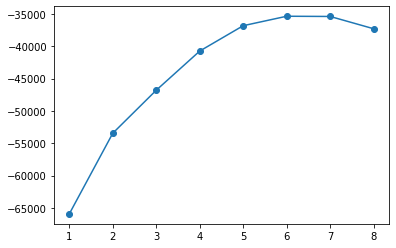

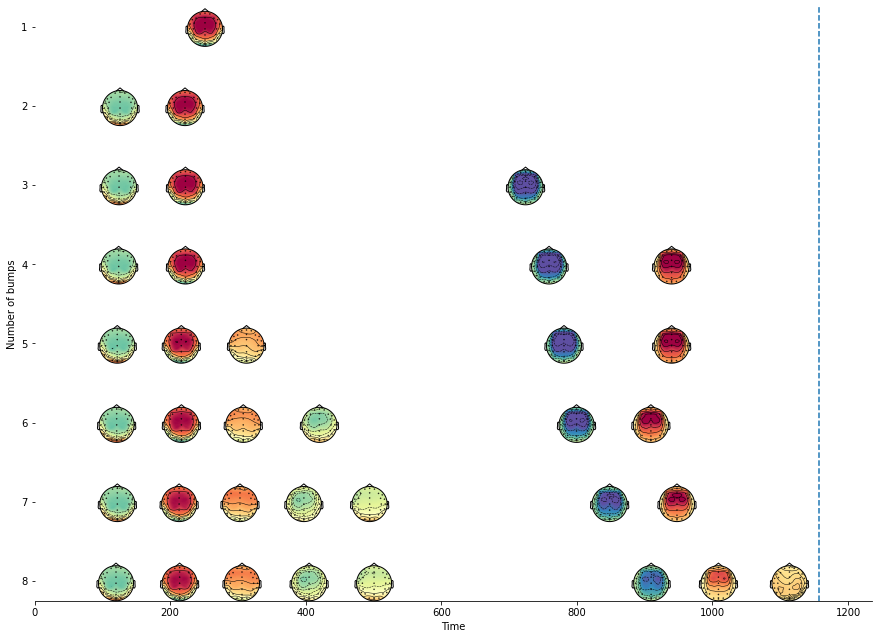

In [7]:
plt.plot(np.arange(init.max_bumps)+1, bests.likelihoods[::-1],'o-')
plt.show()
hsmm.plot_topo_timecourse(electrodes, init.mean_bump_times(bests.eventprobs), positions, bump_size=5, 
                          time_step = 10, magnify=1, mean_rt = np.mean(ends- starts),
    figsize=(15,10), ylabels={'Number of bumps':np.arange(init.max_bumps, 0,-1)},
    vmin=-10, vmax=10)

In [ ]:
subjects_idx = unstacked_data.participant.data
likelihoods_loo = []
cpus = 5
all_n_bumps = []
for n_bumps in np.arange(1,init.max_bumps+1):    
    with multiprocessing.Pool(processes=cpus) as pool:
        loo = pool.starmap(hsmm.LOOCV, 
            zip(itertools.repeat(unstacked_data), subjects_idx, itertools.repeat(n_bumps), 
                itertools.repeat(bests.sel(n_bumps=n_bumps)), itertools.repeat(100)))
    all_n_bumps.append(loo)

loocv = xr.DataArray(np.array(all_n_bumps)[:,:,0].astype(np.float64), coords={"n_bump":np.arange(1,init.max_bumps+1),
                                                           "participants":np.array(all_n_bumps)[0,:,1]})
loocv_covert=loocv

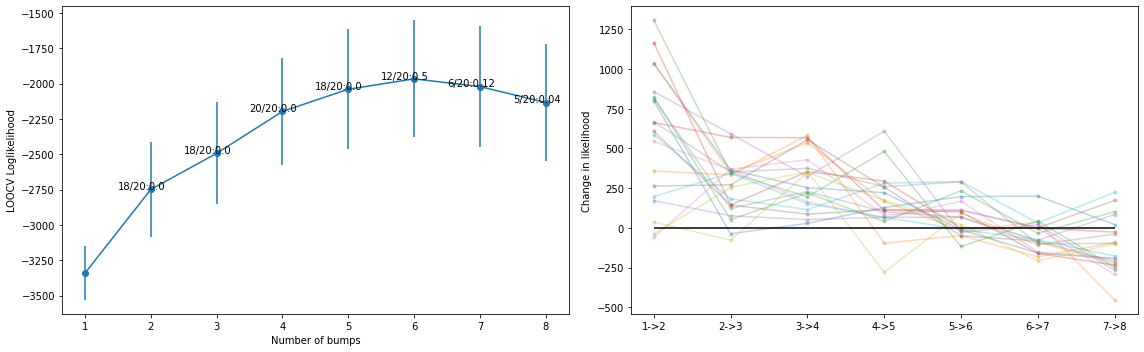

In [12]:
hsmm.plot_LOOCV(loocv)